In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Read in the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


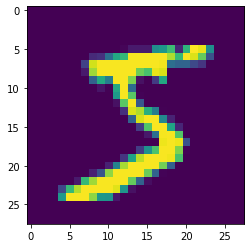

In [3]:
plt.imshow(x_train[0])

In [4]:
# Prepare one-hot encoded y-values
y_train_cat = to_categorical(y=y_train, num_classes=10)
y_test_cat = to_categorical(y=y_test, num_classes=10)

In [5]:
# Normalize image pixel values
x_train = x_train / 255
x_test = x_test / 255

In [6]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [7]:
# Reshaping data to batch_size, width, height, color_channel
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

In [8]:
# Prepare GPU
def prep_gpu():
    phy_gpus = tf.config.list_physical_devices(device_type='GPU')

    for gpu in phy_gpus:
        tf.config.experimental.set_memory_growth(device=gpu, enable=True)

    log_gpus = tf.config.list_logical_devices(device_type='GPU')
    phy_cpus = tf.config.list_physical_devices(device_type='CPU')
    log_cpus = tf.config.list_logical_devices(device_type='CPU')

    print("Physical GPUs: {}\tLogical GPUs: {}\nPhysical CPUs: {}\tLogical CPUs: {}".format(len(phy_gpus),
                                                                                             len(log_gpus),
                                                                                             len(phy_cpus),
                                                                                             len(log_cpus)))

In [9]:
prep_gpu()

Physical GPUs: 0	Logical GPUs: 0
Physical CPUs: 1	Logical CPUs: 1


In [10]:
# Build model
backend.clear_session()
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(4, 4), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Create early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 591,786
Trainable params: 591,786
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Train model with force_CPU
with tf.device(device_name='/device:cpu:0'):
    model.fit(x=x_train, y=y_train_cat, epochs=10, validation_data=(x_test, y_test_cat), callbacks=[early_stop], verbose=1)

Epoch 1/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1430 - accuracy: 0.9568 - val_loss: 0.0525 - val_accuracy: 0.9834
Epoch 2/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0486 - accuracy: 0.9851 - val_loss: 0.0521 - val_accuracy: 0.9832
Epoch 3/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0313 - accuracy: 0.9894 - val_loss: 0.0433 - val_accuracy: 0.9860
Epoch 4/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0213 - accuracy: 0.9934 - val_loss: 0.0405 - val_accuracy: 0.9875
Epoch 5/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0145 - accuracy: 0.9954 - val_loss: 0.0364 - val_accuracy: 0.9893
Epoch 6/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.0547 - val_accuracy: 0.9839


In [12]:
# Model evaluation
metrics = pd.DataFrame(model.history.history)

In [13]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.142984,0.956850,0.052535,0.9834
1,0.048613,0.985117,0.052141,0.9832
2,0.031270,0.989450,0.043276,0.9860
3,0.021290,0.993433,0.040468,0.9875
4,0.014548,0.995350,0.036439,0.9893
5,0.010633,0.996617,0.054745,0.9839


<AxesSubplot:>

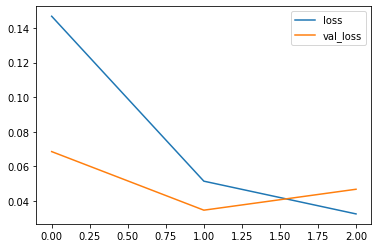

In [14]:
metrics[['loss', 'val_loss']].plot()

<AxesSubplot:>

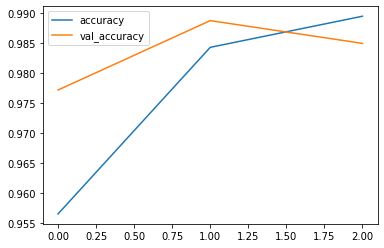

In [15]:
metrics[['accuracy', 'val_accuracy']].plot()

In [16]:
with tf.device(device_name='/device:cpu:0'):
    model.evaluate(x_train, y_train_cat)

1875/1875 [==============================] - 6s 3ms/step - accuracy: 0.9926 - loss: 0.0250


In [17]:
# Make predictions and see classification report
y_pred = np.argmax(model.predict(x_test), axis=-1)

In [18]:
print(classification_report(y_true=np.array(y_test), y_pred=y_pred))
print("\n")
print(confusion_matrix(y_true=np.array(y_test), y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       1.00      0.97      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.96      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.99      0.98      0.98     10000
weighted avg       0.99      0.98      0.98     10000



[[ 967    0    6    1    0    5    1    0    0    0]
 [   0 1133    0    1    0    0    1    0    0    0]
 [   0    5 1021    1    1    0    0    4    0    0]
 [   0    1    2 1004    0    3    0    0    0    0]
 [   0    0    3    0  972 

In [19]:
# Train model with force_GPU
with tf.device(device_name='/device:gpu:0'):
    model.fit(x=x_train, y=y_train_cat, epochs=10, validation_data=(x_test, y_test_cat), callbacks=[early_stop], verbose=1)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - accuracy: 0.9926 - loss: 0.0231 - val_accuracy: 0.9873 - val_loss: 0.0365
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - accuracy: 0.9948 - loss: 0.0158 - val_accuracy: 0.9873 - val_loss: 0.0400


<AxesSubplot:>

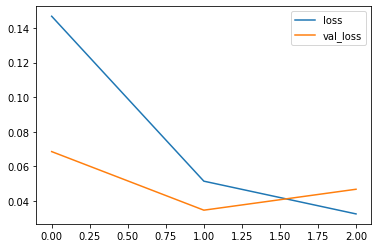

In [20]:
metrics[['loss', 'val_loss']].plot()

<AxesSubplot:>

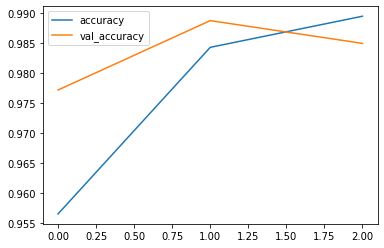

In [21]:
metrics[['accuracy', 'val_accuracy']].plot()

In [22]:
with tf.device(device_name='/device:gpu:0'):
    model.evaluate(x_train, y_train_cat)

1875/1875 [==============================] - 7s 4ms/step - accuracy: 0.9957 - loss: 0.0123


In [23]:
# Make predictions and see classification report
y_pred = np.argmax(model.predict(x_test), axis=-1)

In [24]:
print(classification_report(y_true=np.array(y_test), y_pred=y_pred))
print("\n")
print(confusion_matrix(y_true=np.array(y_test), y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.97      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.98       974
           9       0.96      0.99      0.97      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



[[ 978    0    0    0    0    0    0    0    1    1]
 [   0 1127    1    2    0    0    3    1    1    0]
 [   3    0 1017    1    0    0    0    3    8    0]
 [   0    0    0 1004    0    3    0    0    2    1]
 [   1    0    5    0  949 